<a href="https://colab.research.google.com/github/SevilayMuni/my-bert-fake-news/blob/main/Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detection with BERT

*   Load model and tokenizer from HuggingFace
*   Fine-tune the model and tokenizer on the dataset



## Coding Environment Preparation

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


### Import Libraries

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

import random as rn
import transformers
from transformers import BertConfig
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AdamW, get_scheduler
from transformers import pipeline
from datasets import Dataset

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
from tqdm import tqdm

### Setting Random Seed

In [ ]:
# Setting random seeds for reproducible results
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

## Dataset Preparation

In [ ]:
# Load Dataset
true_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP-projects/True.csv')
fake_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP-projects/Fake.csv')

# Generate labels True/Fake under new Target Column in 'true_data' and 'fake_data'
true_data['Target'] = ['True']*len(true_data)
fake_data['Target'] = ['Fake']*len(fake_data)

# Merge 'true_data' and 'fake_data', by random mixing into a single df called 'data'
data = pd.concat([true_data, fake_data]).sample(frac=1).reset_index().drop(columns=['index'])

# See how the data looks like
print(data.shape)
data.head(10)

(44898, 5)


,title,text,subject,date,Target
0,PHONY HILLARY PULLS THE WOMAN CARD AT JAY-Z/BE...,,left-news,"Nov 5, 2016",Fake
1,Lebanon's cabinet to meet Tuesday for first ti...,BEIRUT (Reuters) - Lebanon s cabinet will meet...,worldnews,"December 4, 2017",True
2,Arkansas attorney general says open to working...,(Reuters) - Arkansas Attorney General Leslie R...,politicsNews,"November 17, 2016",True
3,KASICH WANTS AMNESTY FOR ILLEGALS BUT A GRIEVI...,"The many, many murders and rapes of American c...",politics,"Mar 15, 2016",Fake
4,NYC MAYOR DE BLASIO…Putting Illegal Aliens Bef...,CNN s Jake Tapper asked New York City Mayor Bi...,politics,"Feb 6, 2017",Fake
5,Trump’s Foreign Policy: Promote Stability NOT ...,21st Century Wire says We are sure that the mi...,US_News,"April 27, 2016",Fake
6,Grenades thrown at homes of Ugandan MPs oppose...,KAMPALA (Reuters) - Grenades were thrown overn...,worldnews,"October 3, 2017",True
7,U.S. panel urges ban on China state firms buyi...,WASHINGTON/HONG KONG (Reuters) - U.S. lawmaker...,politicsNews,"November 16, 2016",True
8,George Takei BURIES Trump With Perfect Respon...,Donald Trump attacked the First Amendment on T...,News,"November 29, 2016",Fake
9,AMTRAK FACTS AND WHY AMERICANS SHOULDN’T TRUST...,The Democrats didn t waste any time pushing fo...,politics,"May 15, 2015",Fake


In [ ]:
data['text'][5]

'21st Century Wire says We are sure that the military industrial complex is not at all happy about the prospect of using diplomacy before cruise missiles.In Donald Trump s foreign policy speech today he made numerous points that would lead us to believe that his stance on this area of policy will be radically different to what has become the norm.Aside from the usual campaign rhetoric of ensuring America has the strongest military on the planet, Trump made numerous points clearly stating that the military option will not be his first option.Trump specifically spoke of being very careful as to whom the US assists, particularly in the Middle East, and to only help those who are true allies, which is a clear stab at recent policies to arm and support terrorist groups to overthrow nations like Libya and Syria.He also explicitly stated that the US needs to  stop seeking radical change in the world , and instead look to promote stability through diplomacy saying: Our goal is peace and prospe

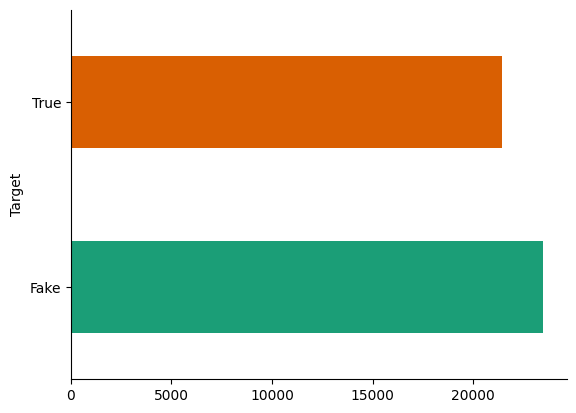

In [ ]:
# Plot distrubition of fake/true news in dataset
data.groupby('Target').size().plot(kind = 'barh',
                                   color = sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

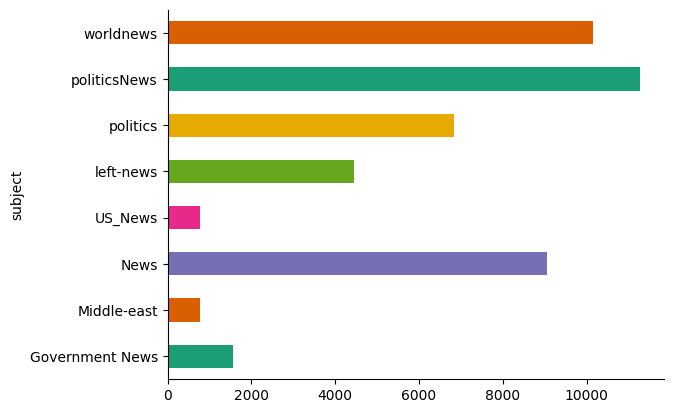

In [ ]:
# Plot distrubition of news subjects in dataset
data.groupby('subject').size().plot(kind = 'barh',
                                    color = sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Target column has string values True/Fake, encode it to 0/1 (Fake=1)
data['label'] = pd.get_dummies(data.Target, dtype = int)['Fake']
data.head()

,title,text,subject,date,Target,label
0,PHONY HILLARY PULLS THE WOMAN CARD AT JAY-Z/BE...,,left-news,"Nov 5, 2016",Fake,1
1,Lebanon's cabinet to meet Tuesday for first ti...,BEIRUT (Reuters) - Lebanon s cabinet will meet...,worldnews,"December 4, 2017",True,0
2,Arkansas attorney general says open to working...,(Reuters) - Arkansas Attorney General Leslie R...,politicsNews,"November 17, 2016",True,0
3,KASICH WANTS AMNESTY FOR ILLEGALS BUT A GRIEVI...,"The many, many murders and rapes of American c...",politics,"Mar 15, 2016",Fake,1
4,NYC MAYOR DE BLASIO…Putting Illegal Aliens Bef...,CNN s Jake Tapper asked New York City Mayor Bi...,politics,"Feb 6, 2017",Fake,1


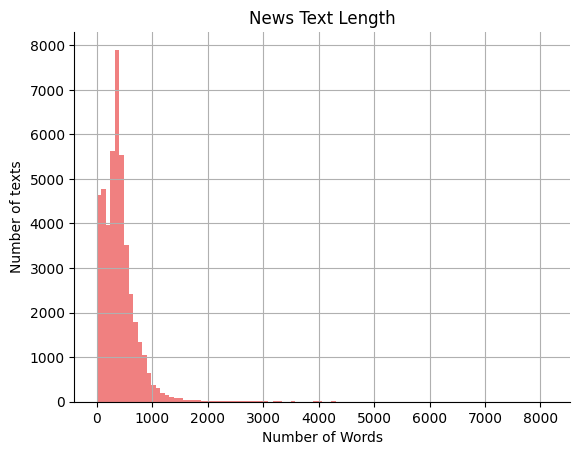

In [ ]:
# Plot histogram of words number in data 'text' column
seq_len = [len(text.split()) for text in data['text']]

pd.Series(seq_len).hist(bins = 100, color = 'lightcoral')
plt.title('News Text Length')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

sns.despine()
plt.show()

## Tokenizer & Model Loading

In [ ]:
# Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Load BERT for sequence classification with binary label output
# Output classes: true and fake, thus num_labels = 2
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 2)
# Move model to the correct device
# Define the device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Data Preprocessing

In [ ]:
# Split train-test dsets wrt 80% - 20%
df = data[['text','label']]
q_80 = int(len(df) * 0.8)

df_train = df[:q_80]
df_test = df[q_80:]

df_train.shape, df_test.shape

((35918, 2), (8980, 2))

In [ ]:
# Convert DataFrames into a Dataset

train_ds = Dataset.from_pandas(df_train)
test_ds = Dataset.from_pandas(df_test)

train_ds, test_ds

(Dataset({
     features: ['text', 'label'],
     num_rows: 35918
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 8980
 }))

### Tokenization

In [ ]:
# Function to preprocess the text into tokens
def preprocess_function(examples):
  return tokenizer(examples['text'],
                   padding = True,
                   truncation = True,
                   return_tensors = 'pt')

In [ ]:
# Tokenize dataset
tokenized_train_ds = train_ds.map(preprocess_function, batched = True)
tokenized_test_ds = test_ds.map(preprocess_function, batched = True)

Map:   0%|          | 0/35918 [00:00<?, ? examples/s]

Map:   0%|          | 0/8980 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_ds, tokenized_test_ds

(Dataset({
     features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 35918
 }),
 Dataset({
     features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 8980
 }))

In [ ]:
# Subsample datasets by select() for faster training
# Since my computer is old, subselected a portion of data
train_dataset = tokenized_train_ds.shuffle(seed = 42).select(range(25000))
test_dataset = tokenized_test_ds.shuffle(seed = 42).select(range(5000))

def format_dataset(batch):
  # Convert the labels and the inputs to PyTorch tensors
  batch['label'] = torch.tensor(batch['label'])
  batch['input_ids'] = torch.tensor(batch['input_ids'])
  batch['attention_mask'] = torch.tensor(batch['attention_mask'])
  return batch

# Apply the formatting to the dataset
train_dataset = train_dataset.map(format_dataset)
test_dataset = test_dataset.map(format_dataset)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
# Used collate_fn to ensure batch data is handled correctly
def collate_fn(batch):
  input_ids = torch.stack([torch.tensor(item['input_ids']) for item in batch])
  attention_mask = torch.stack([torch.tensor(item['attention_mask']) for item in batch])
  labels = torch.tensor([item['label'] for item in batch])

  return {'input_ids': input_ids,
          'attention_mask': attention_mask,
          'labels': labels}

In [ ]:
# Pass collate_fn to the DataLoader to ensure proper batching of data
train_dataloader = DataLoader(train_dataset, batch_size = 32,
                              shuffle = True,
                              collate_fn = collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size = 32,
                             collate_fn = collate_fn)

## Model Training

*   Created optimizer and learning rate scheduler
*   Defined training loop and conducted

In [ ]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr = 5e-5)

# Define the learning rate scheduler
num_training_steps = len(train_dataloader) * 3 # 3 epochs
lr_scheduler = get_scheduler('linear',
                             optimizer = optimizer,
                             num_warmup_steps = 0,
                             num_training_steps = num_training_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Training loop
model.train()

for epoch in range(3): # Train for 3 epochs
  progress_bar = tqdm(train_dataloader, desc = f"Training Epoch {epoch + 1}")

  for batch in progress_bar:
    # Move inputs and labels to appropriate device
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    # Forward pass
    outputs = model(input_ids = input_ids,
                    attention_mask = attention_mask,
                    labels = labels)
    loss = outputs.loss

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()

    progress_bar.set_postfix(loss = loss.item())

Training Epoch 3: 100%|██████████| 782/782 [39:03<00:00,  3.00s/it, loss=6.4e-5]


## Model Testing

*   Defined evaluation loop and got predictions
*   Evaluated model performance on test data



In [ ]:
# Set the model to evaluation mode
model.eval()

all_predictions = []
all_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
  for batch in test_dataloader:
    # Move inputs to appropriate device
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)

    # Get predictions
    outputs = model(input_ids = input_ids,
                    attention_mask = attention_mask)

    # Get logits
    logits = outputs.logits
    # Get predicted class (argmax)
    predictions = torch.argmax(logits, dim = -1)

    # Store predictions and true labels
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

### Model Performance Evaluation

*   Classification Report
*   Confusion Matrix

In [ ]:
# Generate classification report
report = classification_report(all_labels,
                               all_predictions)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2397
           1       1.00      1.00      1.00      2603

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



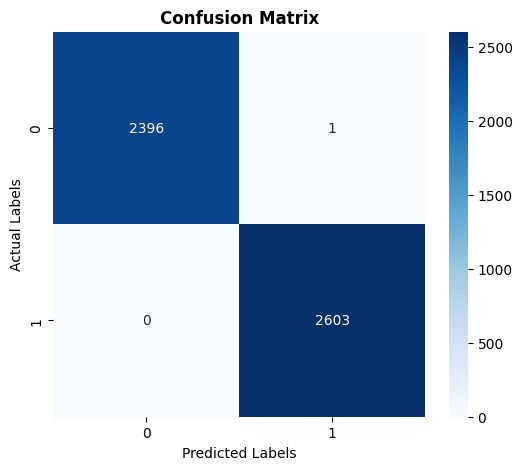

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Visualize confusion matrix
plt.figure(figsize = (6, 5))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix', fontweight = 'bold')
plt.show()

## Fine-Tuned Model & Tokenizer Saving

In [ ]:
# Save the trained model
model.save_pretrained('fake-news-trained-bert-2')

In [ ]:
# Save the tokenizer
tokenizer.save_pretrained('fake-news-trained-bert-2')

('fake-news-trained-bert-2/tokenizer_config.json',
 'fake-news-trained-bert-2/special_tokens_map.json',
 'fake-news-trained-bert-2/vocab.txt',
 'fake-news-trained-bert-2/added_tokens.json')

## Create Pipeline and Get Prediction

In [ ]:
# Directory where your fine-tuned model and tokenizer are saved
MODEL_DIR = "/content/drive/MyDrive/Colab Notebooks/NLP-projects/fake-news-trained-bert-2"

# Create a text classification pipeline
clf = pipeline("text-classification", model=MODEL_DIR, tokenizer=MODEL_DIR)

# Example texts for prediction
texts = [
    "The stock market crashed due to unexpected inflation data.",
    "Scientists discovered a new species of bird in the Amazon rainforest."]

# Get predictions
predictions = clf(texts)

# Output the predictions
for text, prediction in zip(texts, predictions):
    print(f"Text: {text}\nPrediction: {prediction}\n")


Text: The stock market crashed due to unexpected inflation data.
Prediction: {'label': 'LABEL_1', 'score': 0.9559255242347717}

Text: Scientists discovered a new species of bird in the Amazon rainforest.
Prediction: {'label': 'LABEL_1', 'score': 0.9434419870376587}

